In [1]:
include("semantic_parser.jl");

In [2]:
import .CCGSemanticParser.CCGVis: render_parse_tree_latex
import .CCGSemanticParser.CCGs: chart_parse, LexicalEntry, Lexicon, Category, CombinatoryCategorialGrammar,
                                logical_form, @primitive_syntactic_type
import .CCGSemanticParser.LambdaCalculus: @variable, @constant, lambda, ≃, LambdaTerm
import .CCGSemanticParser.LambdaLogic: @predicate, PredicateFormula, predicate, arguments, and

In [3]:
λ = lambda; # aesthetics

## The Grammar

In [4]:
@primitive_syntactic_type Det NP N ADJ S P PP

@variable x y z f

@constant nil
@constant box can bottle meat soup sugar gelatin mustard cracker bleach 

@predicate Shape Exists ExistsUnique Content 2
@predicate OnTopOf Underneath RightOf LeftOf InFrontOf Behind 2
@predicate Fetch 1;

In [5]:
ignore(n::Int, t::LambdaTerm) = n == 0 ? t : ignore(n-1, lambda(z, t));

In [6]:
function factored_lexical_entries(lexemes, template)
    [LexicalEntry(str, template(symbs...)) for (str, symbs) in lexemes]
end
function factored_type_shifting_rules(lexemes, template)
    [str => template(symbs...) for (str, symbs) in lexemes]
end;

In [7]:
lexicon = Lexicon([
    LexicalEntry("fetch", S/NP, λ(x, Fetch(x))),
    LexicalEntry("on", P(:on), nil),
    LexicalEntry("of", P(:of), nil),
    LexicalEntry("in", P(:in), nil),
    LexicalEntry("the", Det(:the), λ(f, ExistsUnique(x, f(x)))),

    # XXX I know this is hacky, but good enough for now
    LexicalEntry("top", ((N\N)/NP)/P(:of)\P(:on), ignore(2, λ(x, λ(f, λ(y, and(f(y), OnTopOf(y, x))))))),
    LexicalEntry("underneath", (N\N)/NP, λ(x, λ(f, λ(y, and(f(y), Underneath(y, x)))))),
    LexicalEntry("right", ((((N\N)/NP)/P(:of))\P(:on))\Det(:the), ignore(3, λ(x, λ(f, λ(y, and(f(y), RightOf(y, x))))))),
    LexicalEntry("left", ((((N\N)/NP)/P(:of))\P(:on))\Det(:the), ignore(3, λ(x, λ(f, λ(y, and(f(y), LeftOf(y, x))))))),
    LexicalEntry("behind", (N\N)/NP, λ(x, λ(f, λ(z, and(f(z), Behind(z, x)))))),
    LexicalEntry("front", (((N\N)/NP)/P(:of))\P(:in), ignore(2, λ(x, λ(f, λ(y, and(f(y), InFrontOf(y, x))))))),

    LexicalEntry("a", NP/N, λ(f, Exists(x, f(x)))),
    LexicalEntry("the", NP/N, λ(f, ExistsUnique(x, f(x)))),
    LexicalEntry("and", (S\S)/S, λ(x, λ(y, and(y, x)))),

    factored_lexical_entries([("meat", (meat,)), ("soup", (soup,)),
                              ("sugar", (sugar,)), ("gelatin", (gelatin,)),
                              ("mustard", (mustard,)), ("bleach", (bleach,)),
                              ("cracker", (cracker,))],
                             fn->Category(N, λ(x, fn(x))))...,

    factored_lexical_entries([("box", (box,)), ("can", (can,)), ("bottle", (bottle,))],
                             shape->Category(N, λ(x, Shape(x, shape))))...
])

type_shifting_rules = Dict{String, Vector{Category}}(
    factored_type_shifting_rules([("meat", (meat,)), ("soup", (soup,)),
                                  ("sugar", (sugar,)), ("gelatin", (gelatin,)),
                                  ("mustard", (mustard,)), ("bleach", (bleach,)),
                                  ("cracker", (cracker,))],
                                 content->[Category(N/N, λ(f, λ(x, and(f(x), Content(x, content)))))])...
)
                   
grammar = CombinatoryCategorialGrammar(lexicon, type_shifting_rules);

In [8]:
parses = chart_parse("the can behind the box underneath the mustard bottle", grammar);

In [9]:
differnt_parse_idx = findfirst(pt->!(logical_form(pt.cat) ≃ logical_form(parses[1].cat)), parses);

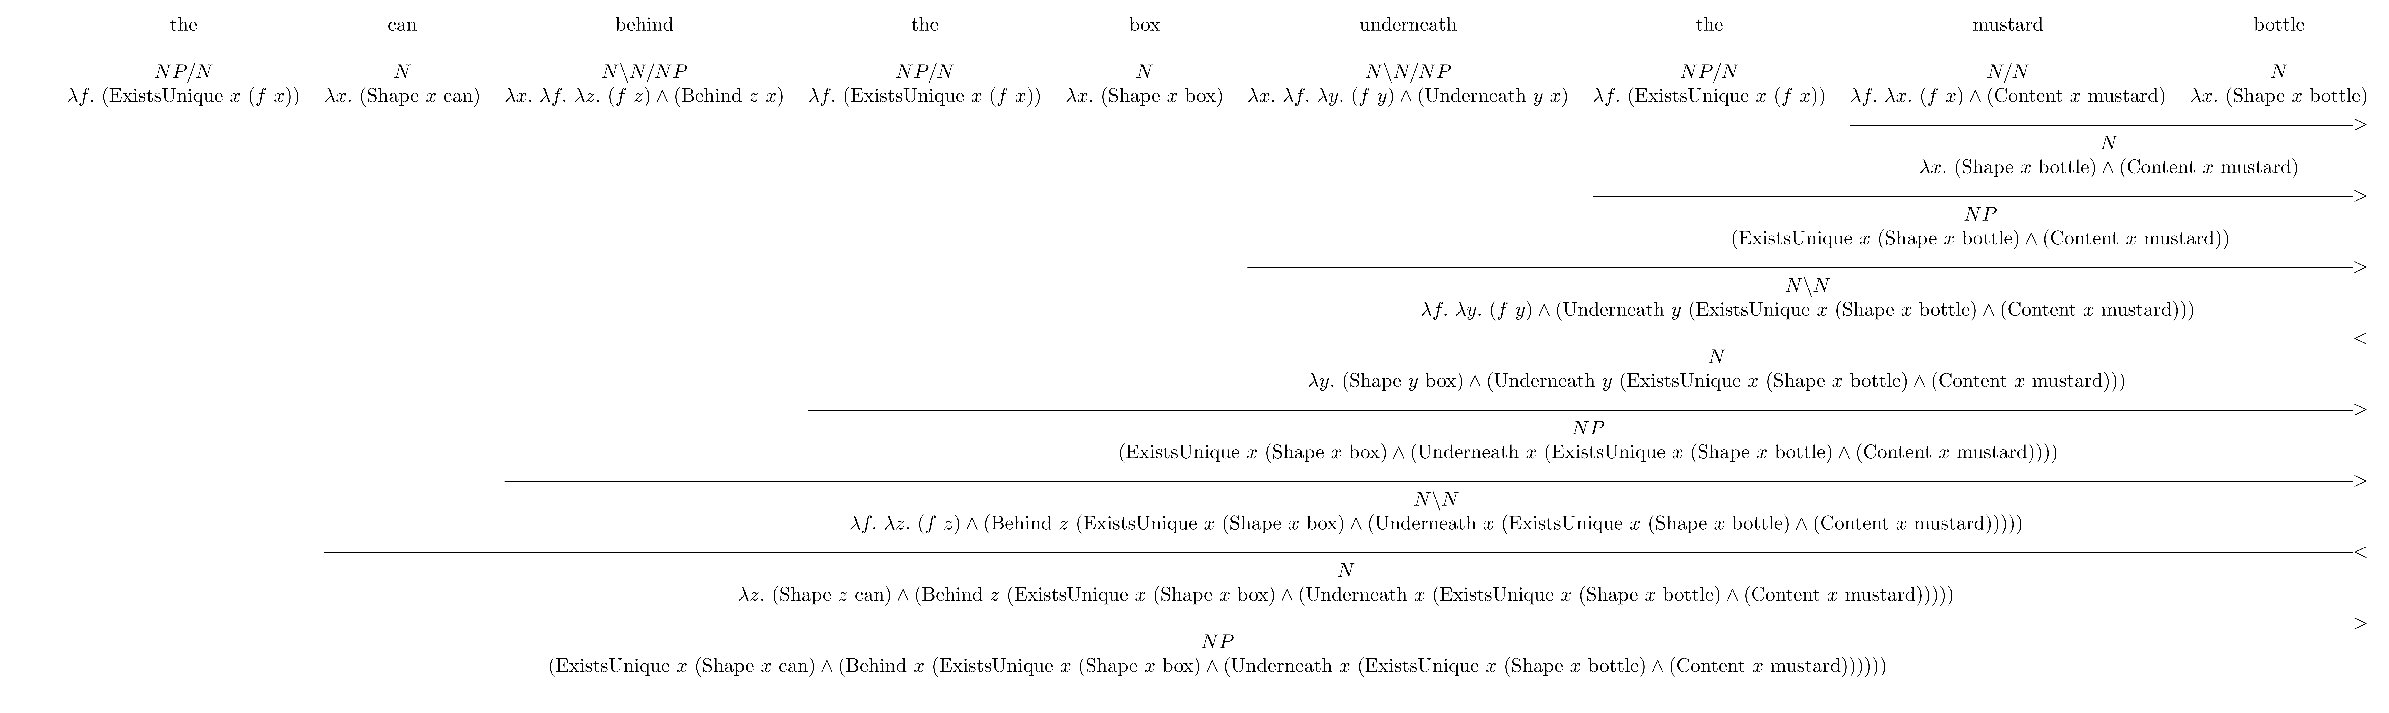

In [10]:
render_parse_tree_latex(parses[1]);

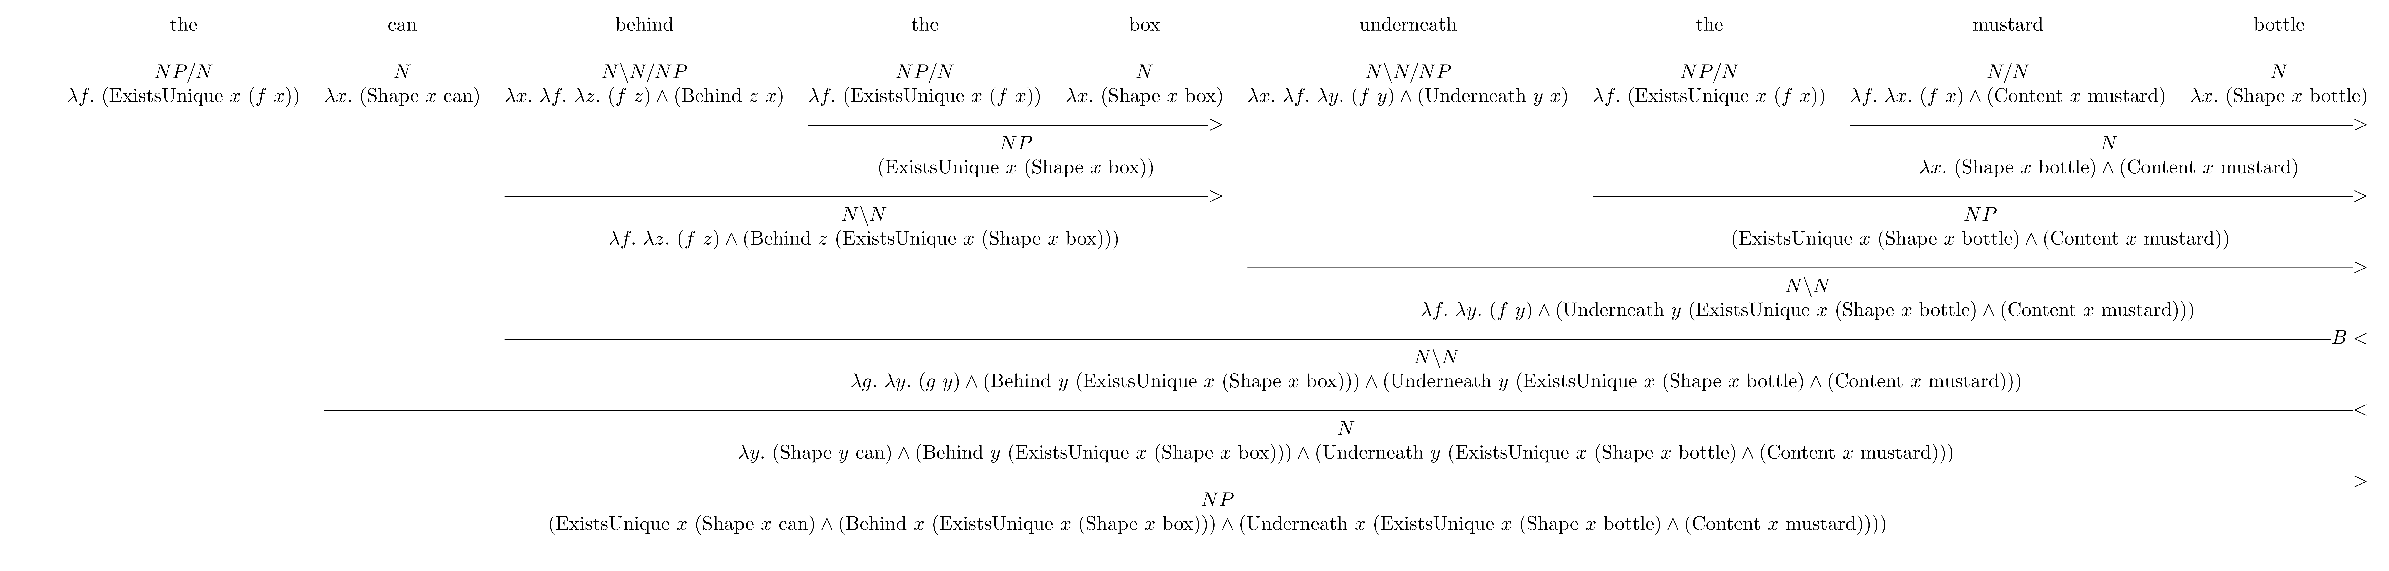

In [11]:
render_parse_tree_latex(parses[differnt_parse_idx]);